In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from wordcloud import WordCloud
import statsmodels.api as sm

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

## Load the houseprices data from Thinkful's database.

In [54]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

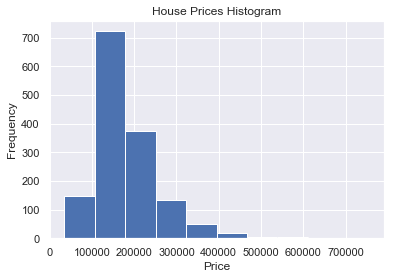

In [55]:
#view the target variable as a histogram

plt.hist(house_prices_df.saleprice)
plt.title("House Prices Histogram")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The histogram of House Prices is not normally distributed, but instead is skewed right.

In [24]:
#examine the data frame

print(
    house_prices_df.head(),
    house_prices_df.info(),
    house_prices_df.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [22]:
#determine which variables have missing values and in what percentage

missing_values_ratios = (house_prices_df.isnull().sum()/house_prices_df.isnull().count())
missing_values_ratios.sort_values(ascending=False).head(30)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
yearremodadd    0.000000
mssubclass      0.000000
foundation      0.000000
extercond       0.000000
exterqual       0.000000
exterior2nd     0.000000
exterior1st     0.000000
roofmatl        0.000000
roofstyle       0.000000
yearbuilt       0.000000
dtype: float64

It appears that most of the columns are not missing data, so we will avoid using the ones that are.

In [34]:
#check the correlation of the numerical variables with the target
np.abs(house_prices_df[house_prices_df.select_dtypes(['int64', 'float64']).columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False).head(10)

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
Name: saleprice, dtype: float64

We would like to use the top 5 most correlated variables for our model, but let's check to see how they correlate with each other first (since one of the assumptions of linear regression is that features are at most only weakly correlated).

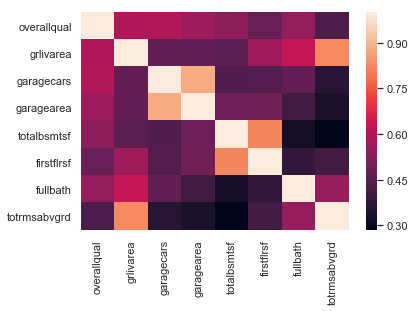

In [37]:
potential_features = ['overallqual', 'grlivarea', 'garagecars', 'garagearea', 
                      'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd']

sns.heatmap(house_prices_df[potential_features].corr())

There is high correlation between (totrmsabvgrd and grlivarea), (garagecars and garagearea), and (totalbsmtsf and firstflrsf).  For our model, we use overallqual, grlivarea, garagecars, totalbsmtsf, and fullbath.  The variables garagearea and firstflrsf are withheld due to their high correlation with other features.

In [56]:
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'fullbath']]
Y = house_prices_df.saleprice

## Run your house prices model again and interpret the results. Which features are statistically significant, and which are not?

In [57]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     924.4
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:25:06   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1454   BIC:                         3.504e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.946e+04   4664.407    -21.323      0.000   -1.09e+05   -9.03e+04
overallqual  2.347e+04   1096.846     21.396      0.000    2.13e+04    2.56e+04
grlivarea      45.0948      2.763     16.322      0.000      39.675      50.514
garagecars   1.846e+04   1770.103     10.426      0.000     1.5e+04    2.19e+04
totalbsmtsf    32.6241      2.848     11.455      0.000      27.038      38.211
fullbath     1143.2224   2519.600      0.454      0.650   -3799.216    6085.661
==============================================================================
Omnibus:                      418.319   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36201.837
Skew:                          -0.256   Prob(JB):                         0.00
Kurtosis:                      27.389   Cond. No.                     9.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Of the five features initially chosen for the model, only _fullbath_ is not statistically significant.

## Now, exclude the insignificant features from your model. Did anything change?

In [58]:
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf']]
Y = house_prices_df.saleprice

In [59]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1156.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:26:37   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1455   BIC:                         3.504e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.925e+04   4639.866    -21.390      0.000   -1.08e+05   -9.01e+04
overallqual  2.357e+04   1072.465     21.980      0.000    2.15e+04    2.57e+04
grlivarea      45.6432      2.484     18.376      0.000      40.771      50.515
garagecars   1.858e+04   1747.412     10.634      0.000    1.52e+04     2.2e+04
totalbsmtsf    32.5203      2.838     11.459      0.000      26.953      38.087
==============================================================================
Omnibus:                      421.692   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36798.858
Skew:                          -0.273   Prob(JB):                         0.00
Kurtosis:                      27.589   Cond. No.                     8.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After excluding the insignificant feature, not much seems to have changed with the model based on the summary statistics.

## Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?

Of the features included in the model, _overallqual_ has the greatest effect on the target, with an increase in 1 quality unity (this feature is a score from 1-10, with 10 being the best) resulting in a target incease of ~ 2400 dollars.  Next, _garagecars_, which reports the size of the garage in car capacity, results in a target increase of about 1900 dollars.  When the feature _grlivarea_ increases by one square foot the target increases by ~ 46 dollars, and an increase in feature _totalbsmtsf_ by one square foot increases the target by ~ 33 dollars.  The features _overallqual_ and _garagecars_ have a much larger effect on the target per unit feature change, but they also have much smaller domains than _grlivarea_ and _totalbsmtsf_, so we are not sure how to decide which features are ultimately more prominent (nor are we sure what is meant exactly by *prominence* in this context).